## Base Model Prediksi Titik Panas di Sumatera Selatan 2001 - 2023

In [1]:
# pustaka manipulasi data array
import numpy as np

# pustaka manipulasi data frame
import pandas as pd
import random as rm
import time as tm

# pustaka untuk visualisasi data
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# library normalize data with max-min algorithm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# library algorithm lstm-rnn with keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import RNN
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.optimizers import Adam, Adamax, RMSprop, SGD
from keras.layers import LeakyReLU

# pustaka untuk visualisasi acf dan pacf
import scipy.stats as sc
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

# pustaka untuk  evaluasi model prediksi
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

### Config Models

In [2]:
# Setting seed
rm.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [3]:
# Setting Algorithm
algorithm = "LSTM-RNN"

### 1. Akuisisi Data

In [4]:
# Set waktu komputasi
start = tm.time()

In [5]:
dataset = pd.read_csv("dataset/dataset_hotspot.csv", parse_dates=["acq_date"])

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   acq_date  276 non-null    datetime64[ns]
 1   hotspot   276 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.4 KB


In [7]:
print(dataset)

      acq_date  hotspot
0   2001-01-31        3
1   2001-02-28        5
2   2001-03-31       10
3   2001-04-30       20
4   2001-05-31       39
..         ...      ...
271 2023-08-31      186
272 2023-09-30     2247
273 2023-10-31     3200
274 2023-11-30      390
275 2023-12-31       42

[276 rows x 2 columns]


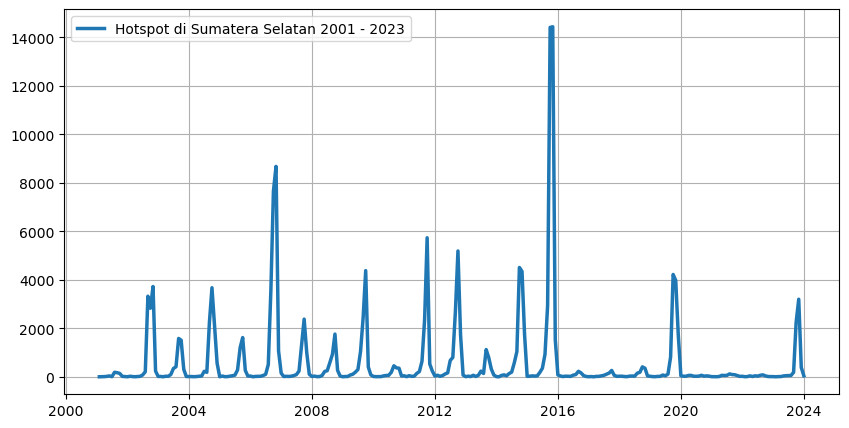

In [8]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset["acq_date"], dataset["hotspot"], color="tab:blue", label="Hotspot di Sumatera Selatan 2001 - 2023", linewidth=2.5)

# membuat label-label
ax.set_title("", fontsize=14)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="upper left")
ax.grid(True)

# menampilkan plot
plt.show()

### 2. PraProses Data

- Seleksi Fitur

In [9]:
# hanya memperhatikan aspek hotspot
data = dataset.filter(["hotspot"])
data = data.values

In [10]:
# hasil seleksi fitur
np.round(data[:5],7)

array([[ 3],
       [ 5],
       [10],
       [20],
       [39]], dtype=int64)

In [11]:
# cek dimensi normalisasi
data.shape

(276, 1)

- Normalisasi Data

In [12]:
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(np.array(data))

In [13]:
# cek dimensi normalisasi
scaled.shape

(276, 1)

- Hasil PraProses Data

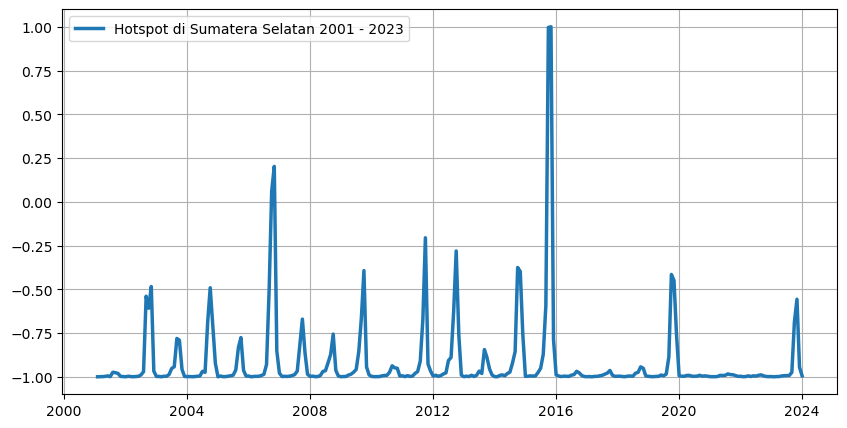

In [14]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset["acq_date"], np.array(scaled), color="tab:blue", label="Hotspot di Sumatera Selatan 2001 - 2023", linewidth=2.5)

# membuat label-label
ax.set_title("", fontsize=14)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="upper left")
ax.grid(True)

# menampilkan plot
plt.show()

### 3. Pembagian Data

In [15]:
# Data latih th 2001 - 2018 = 216 baris
# Data uji th 2019 - 2023 = 60 baris

In [16]:
# split data train and test
train_data, test_data = train_test_split(scaled, train_size=0.80, test_size=0.20, shuffle=False)

In [17]:
# # data train
# train_size = 216

# # set loc data train
# train_data = scaled[0:train_size,:]

# # show data train
# np.round(train_data[:5],7)

In [18]:
train_data.shape

(220, 1)

In [19]:
# # data test
# test_size = 60

# # set loc data test
# test_data = scaled[train_size:len(scaled),:]

# # show data test
# np.round(test_data[:5],7)


In [20]:
test_data.shape

(56, 1)

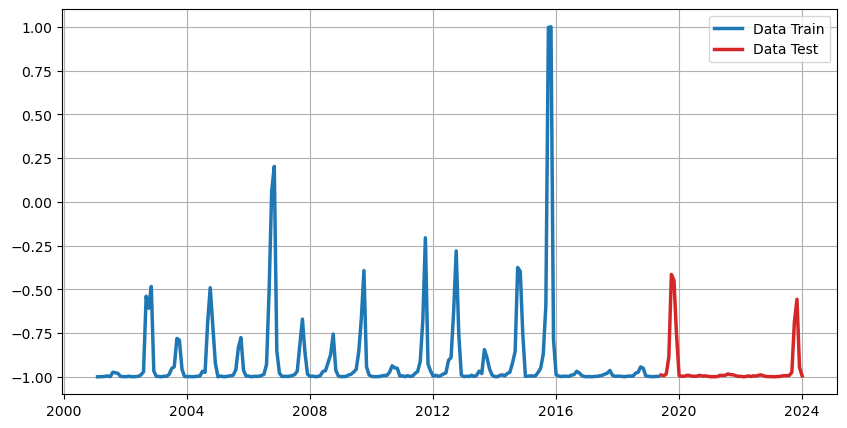

In [21]:
# make a frame
fig, ax = plt.subplots(figsize = (10,5))

# make a time series plot
ax.plot(dataset.iloc[0:len(train_data),0], train_data, color="tab:blue", label="Data Train", linewidth=2.5)
ax.plot(dataset.iloc[len(train_data):len(dataset),0], test_data, color="tab:red", label="Data Test", linewidth=2.5)

# make are labels
# ax.set_title("Hotspot Sumsel Sensor MODIS 2001-2020", fontsize=14)
# ax.set_xlabel("Years", fontsize=12)
# ax.set_ylabel("Sum of hotspot", fontsize=12)
ax.legend(loc="best")
ax.grid(True)

# show plot time series
plt.show()

### 4. Supervised Learning

In [22]:
# function for supervised learning
def create_dataset(look_back, dataset):
    
    # declare variable X and Y
    dataX = []
    dataY = []
    
    # for loop for create supervised learning
    for i in range(look_back, len(dataset)):
        
        # insert value X and Y 
        dataX.append(dataset[i-look_back:i, 0])
        dataY.append(dataset[i, 0])
        
    # return value X and Y
    return np.array(dataX), np.array(dataY)

In [23]:
# set time series lag
look_back = 1

In [24]:
# Proses supervised learning
x_train, y_train = create_dataset(look_back, train_data)
print(x_train.shape, y_train.shape)

(219, 1) (219,)


In [25]:
# Proses supervised learning
x_test, y_test = create_dataset(look_back, test_data)
print(x_test.shape, y_test.shape)

(55, 1) (55,)


In [26]:
# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

- hasil supervised learning

In [27]:
# cek dimensi data
print(x_train.shape, x_test.shape)

(219, 1, 1) (55, 1, 1)


### 5. Model Prediksi Titik Panas

In [28]:
# set parameter
activation = "selu"
dropout_rate = 0.15
optimizer = "sgd"

# call model LSTM-RNN
from class_base_model import lstm_algorithm
model = lstm_algorithm(x_train, activation, dropout_rate, optimizer)

# # # call model GRU-RNN
# from class_base_model import gru_algorithm
# model = gru_algorithm(x_train, activation, dropout_rate, optimizer)

In [29]:
# fit network
history = model.fit(x_train, y_train, batch_size=4, epochs=2500, validation_data=(x_test, y_test), verbose=0, shuffle=False, use_multiprocessing=True)

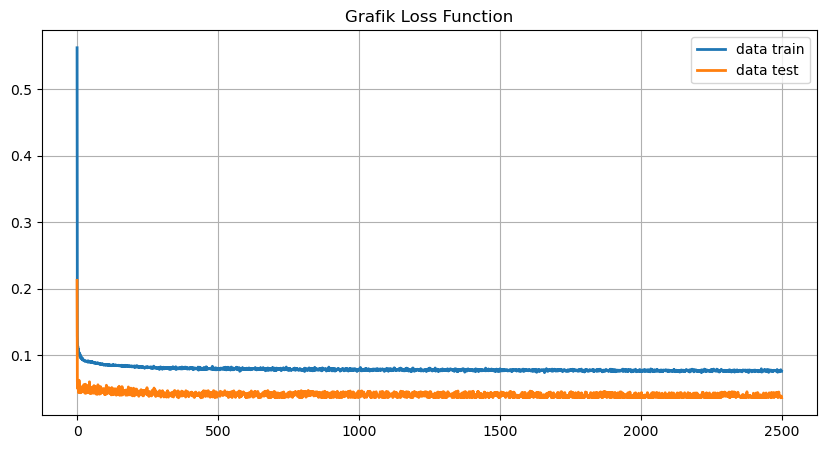

In [30]:
# show plot loss function
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(history.history['loss'], color="tab:blue", label="data train", linewidth=2)
ax.plot(history.history['val_loss'], color="tab:orange", label="data test", linewidth=2)

# membuat label-label
ax.set_title("Grafik Loss Function")
ax.legend(loc="best")
ax.grid(True)

# menampilkan plot
plt.show()

In [31]:
# 5. make predictions
predictions = model.predict(x_test, verbose=0)
print(predictions[:, 0])

[-0.99317896 -0.9946479  -0.9885488  -0.9062286  -0.7101363  -0.7137608
 -0.8178731  -0.9946093  -0.99530375 -0.9954194  -0.99406135 -0.9940219
 -0.99530375 -0.9954194  -0.9952266  -0.9937651  -0.9952266  -0.99480236
 -0.99518806 -0.9960355  -0.9961124  -0.9961124  -0.99576604 -0.9939229
 -0.9941402  -0.9939229  -0.9879085  -0.9912161  -0.9920074  -0.99437606
 -0.99557346 -0.9954579  -0.9961124  -0.9958815  -0.99476373 -0.99580455
 -0.99468654 -0.99518806 -0.9938177  -0.99253047 -0.99480236 -0.99576604
 -0.9959585  -0.99592006 -0.9962278  -0.99592006 -0.9958815  -0.99499524
 -0.9944934  -0.99441534 -0.99417955 -0.9796805  -0.7747729  -0.72674114
 -0.9546018 ]


### 6. Evaluasi Model

In [32]:
mae = mean_absolute_error(y_test, predictions) * 100
print('Test MAE : %.4f' % mae)

Test MAE : 3.6125


In [33]:
mse = mean_squared_error(y_test, predictions) * 100
print('Test MSE: %.4f' % mse)

Test MSE: 0.9728


In [34]:
mape = mean_absolute_percentage_error(y_test, predictions) * 100
print('Test MAPE: %.2f' % mape)

Test MAPE: 6.08


In [35]:
hasil = np.stack((y_test.reshape(-1), predictions.reshape(-1)), axis=1)
hasil = pd.DataFrame(hasil, columns = ['data_aktual','prediksi'])
hasil.head()

,data_aktual,prediksi
0,-0.994319,-0.993179
1,-0.984343,-0.994648
2,-0.887211,-0.988549
3,-0.415270,-0.906229
4,-0.449494,-0.710136


In [36]:
r, p = sc.pearsonr(hasil["data_aktual"], hasil["prediksi"])
print("korelasi data akual dengan hasil prediksi" +" {:.4f} ".format(r)+ "dengan signifikansi" +" {:.4f} ".format(p))

korelasi data akual dengan hasil prediksi 0.6522 dengan signifikansi 0.0000 


- Kompleksitas waktu  

In [37]:
# Set akhir waktu komputasi 
end = tm.time()

In [38]:
# Proses menghitung waktu komputasi
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)

In [39]:
# Hasil waktu komputasi
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

00:13:15.26


### 7. Visualisasi Data

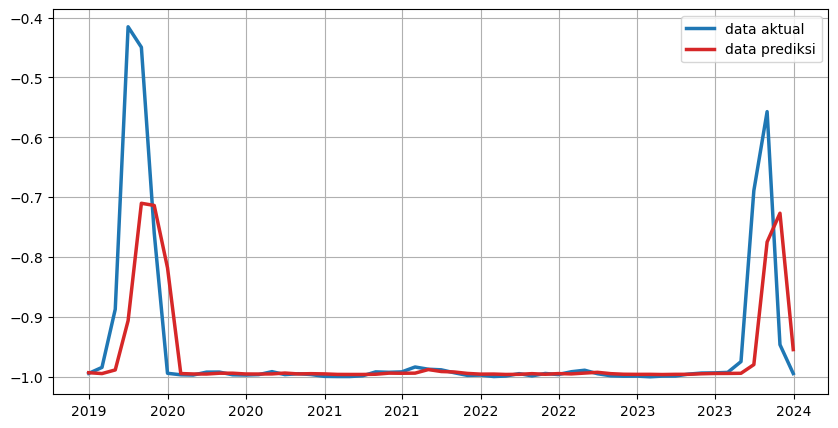

In [40]:
# membuat frame
fig, ax = plt.subplots(figsize = (10,5))

# membuat time series plot
ax.plot(dataset.iloc[len(train_data)+1:len(dataset),0], y_test, color="tab:blue", label="data aktual", linewidth=2.5)
ax.plot(dataset.iloc[len(train_data)+1:len(dataset),0], predictions, color="tab:red", label="data prediksi", linewidth=2.5)

# membuat label-label
ax.set_title("", fontsize=14)
ax.legend(loc="best")
ax.grid(True)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.show()